# 1.4.1 Loading Datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Spiral:
    def load_data(seed=1984):
        np.random.seed()
        N = 100  
        DIM = 2  
        CLS_NUM = 3 

        x = np.zeros((N*CLS_NUM, DIM)) # 輸入資料
        t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int) # 標籤資料

        for j in range(CLS_NUM):
            for i in range(N):
                rate = i / N
                radius = 1.0*rate
                theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

                ix = N*j + i
                x[ix] = np.array([radius*np.sin(theta),
                                  radius*np.cos(theta)]).flatten()
                t[ix, j] = 1

        return x, t

x: (300, 2)
t: (300, 3)


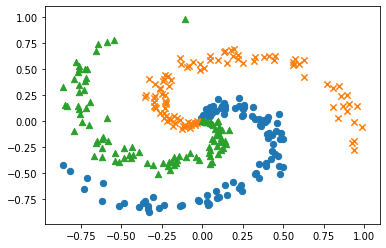

In [3]:
spiral = Spiral()
x, t = spiral.load_data()
print('x:', x.shape)  
print('t:', t.shape)  

N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']

for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

# 1.4.2 Building Neural Network

In [4]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [5]:
class Sigmoid:
    def __init__(self):
        self.params = list()
        self.grads = list()
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [6]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [8]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params = list()
        self.grads = list()
        self.y = None  
        self.t = None  

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [9]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        self.params = list()
        self.grads = list()
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [10]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

# 1.4.3 Training Neural Network

| epoch 1    | iter 10 / 10   | loss1.1431240254494823
| epoch 11   | iter 10 / 10   | loss1.1413586386991696
| epoch 21   | iter 10 / 10   | loss1.1160049540518724
| epoch 31   | iter 10 / 10   | loss1.1378081523137207
| epoch 41   | iter 10 / 10   | loss1.13643510197233
| epoch 51   | iter 10 / 10   | loss1.1201696021799343
| epoch 61   | iter 10 / 10   | loss1.1790004153868385
| epoch 71   | iter 10 / 10   | loss1.1608741455559772
| epoch 81   | iter 10 / 10   | loss1.149069916494264
| epoch 91   | iter 10 / 10   | loss1.119666806978631
| epoch 101  | iter 10 / 10   | loss1.1031579838450474
| epoch 111  | iter 10 / 10   | loss1.0797546582640924
| epoch 121  | iter 10 / 10   | loss1.065318614447027
| epoch 131  | iter 10 / 10   | loss1.027386580137701
| epoch 141  | iter 10 / 10   | loss0.9923491273151669
| epoch 151  | iter 10 / 10   | loss0.9691102451134848
| epoch 161  | iter 10 / 10   | loss0.9245614420529116
| epoch 171  | iter 10 / 10   | loss0.8916143505575361
| epoch 181  | i

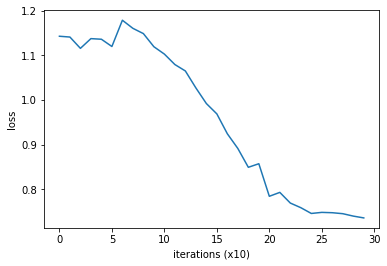

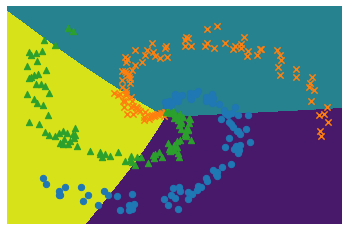

In [11]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    if epoch % 10 == 0:
        idx = np.random.permutation(data_size)
        x = x[idx]
        t = t[idx]

        for iters in range(max_iters):
            batch_x = x[iters*batch_size:(iters+1)*batch_size]
            batch_t = t[iters*batch_size:(iters+1)*batch_size]

            loss = model.forward(batch_x, batch_t)
            model.backward()
            optimizer.update(model.params, model.grads)

            total_loss += loss
            loss_count += 1

            if (iters+1) % 10 == 0:
                avg_loss = total_loss / loss_count
    #             print('| epoch %d |  iter %d / %d | loss %.2f' % (epoch + 1, iters + 1, max_iters, avg_loss))
                print('| epoch {:<5}| iter {} / {:<5}| loss{}'.format(epoch + 1, iters + 1, max_iters, avg_loss))
                loss_list.append(avg_loss)
                total_loss = 0
                loss_count = 0

plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

# 1.4.4 Trainer Class

In [12]:
import time

In [13]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]  
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [14]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            if epoch % 10 == 0:
                idx = np.random.permutation(np.arange(data_size))
                x = x[idx]
                t = t[idx]

                for iters in range(max_iters):
                    batch_x = x[iters*batch_size:(iters+1)*batch_size]
                    batch_t = t[iters*batch_size:(iters+1)*batch_size]

                    loss = model.forward(batch_x, batch_t)
                    model.backward()
                    params, grads = remove_duplicate(model.params, model.grads)
                    if max_grad is not None:
                        clip_grads(grads, max_grad)
                    optimizer.update(params, grads)
                    total_loss += loss
                    loss_count += 1

                    if (eval_interval is not None) and (iters % eval_interval) == 0:
                        avg_loss = total_loss / loss_count
                        elapsed_time = time.time() - start_time
#                         print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f' % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                        print('| epoch {:<5} |  iter {} / {:<5} | time {:<25} | loss {}'.format(self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                        self.loss_list.append(float(avg_loss))
                        total_loss = 0
                        loss_count = 0

                self.current_epoch += 1
            
    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

| epoch 1     |  iter 1 / 10    | time 0.0005030632019042969     | loss 1.0957898885073314
| epoch 2     |  iter 1 / 10    | time 0.005744218826293945      | loss 1.1501747072883406
| epoch 3     |  iter 1 / 10    | time 0.009068012237548828      | loss 1.1099246656604913
| epoch 4     |  iter 1 / 10    | time 0.012306928634643555      | loss 1.1223756598622165
| epoch 5     |  iter 1 / 10    | time 0.016973018646240234      | loss 1.115953511436273
| epoch 6     |  iter 1 / 10    | time 0.03376412391662598       | loss 1.163560662090116
| epoch 7     |  iter 1 / 10    | time 0.036978960037231445      | loss 1.117580312324639
| epoch 8     |  iter 1 / 10    | time 0.040287017822265625      | loss 1.1304649902010984
| epoch 9     |  iter 1 / 10    | time 0.0430910587310791        | loss 1.1494157012867257
| epoch 10    |  iter 1 / 10    | time 0.04718518257141113       | loss 1.143907797414991
| epoch 11    |  iter 1 / 10    | time 0.049859046936035156      | loss 1.1044696991444307
| e

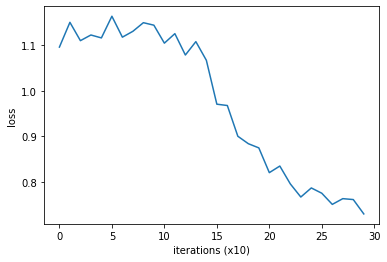

In [15]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
trainer.plot()